In [1]:
import pandas as pd
#显示所有列
pd.set_option('display.max_columns', None)
#显示所有行
pd.set_option('display.max_rows', None)
#设置value的显示长度为100，默认为50
pd.set_option('max_colwidth',100)

In [2]:
import numpy as np
import lightgbm as lgb
from sklearn.metrics import mean_squared_error as mse
from tqdm import tqdm, tqdm_notebook
import warnings
warnings.filterwarnings('ignore')
 
path = '../ccf_car/'
train_sales_data = pd.read_csv(path+'train_sales_data.csv', engine='python')
train_search_data = pd.read_csv(path+'train_search_data.csv', engine='python')
train_user_reply_data = pd.read_csv(path+'train_user_reply_data.csv', engine='python')
test = pd.read_csv(path+'evaluation_public.csv', engine='python')
 
# train_sales_data\train_search_data\train_user_reply_data  拼接
data = pd.merge(train_sales_data, train_search_data, 'left', on=['province', 'adcode', 'model', 'regYear', 'regMonth'])
data = pd.merge(data, train_user_reply_data, 'left', on=['model', 'regYear', 'regMonth'])
 
# col, col2, col3 中 ，设1.5倍四分位距之外的数据为异常值，用上下四分位数的均值填充
col, col2, col3 = ['popularity', 'carCommentVolum', 'newsReplyVolum']
col_per = np.percentile(data[col],(25,75))
diff = 1.5*(col_per[1] - col_per[0])
col_per_in = (data[col] >= col_per[0] - diff) & (data[col] <= col_per[1] + diff)
 
col_per2 = np.percentile(data[col2],(25,75))
diff2 = 1.5*(col_per2[1] - col_per2[0])
col_per_in2 = (data[col2] >= col_per2[0] - diff2) & (data[col2] <= col_per2[1] + diff2)
 
col_per3 = np.percentile(data[col3],(25,75))
diff3 = 1.5*(col_per3[1] - col_per3[0])
col_per_in3 = (data[col3] >= col_per3[0] - diff3) & (data[col3] <= col_per3[1] + diff3)
 
data.loc[~col_per_in, col] = col_per.mean()
data.loc[~col_per_in2, col2] = col_per2.mean()
data.loc[~col_per_in3, col3] = col_per3.mean()
 
# 统计销量
data['bt_ry_mean'] = data.groupby(['bodyType','regYear'])['salesVolume'].transform('mean')
data['ad_ry_mean'] = data.groupby(['adcode','regYear'])['salesVolume'].transform('mean')
data['md_ry_mean'] = data.groupby(['model','regYear'])['salesVolume'].transform('mean')
 
 
'''
一、lgb预测
'''
# 测试集并入
data = pd.concat([data, test], ignore_index=True)
data['label'] = data['salesVolume']
data['id'] = data['id'].fillna(0).astype(int)
del data['salesVolume'], data['forecastVolum']
# 填补测试集的车身类型
data['bodyType'] = data['model'].map(train_sales_data.drop_duplicates('model').set_index('model')['bodyType'])
# 编码 bodyType、model
for i in ['bodyType', 'model']:
    data[i] = data[i].map(dict(zip(data[i].unique(), range(data[i].nunique()))))
# 距离2016年的时间间隔，月数
data['mt'] = (data['regYear'] - 2016) * 12 + data['regMonth']
 
shift_feat = []
data['model_adcode'] = data['adcode'] + data['model']
data['model_adcode_mt'] = data['model_adcode'] * 100 + data['mt']
 
# 填充测试集特征值
for col in ['carCommentVolum','newsReplyVolum','popularity','bt_ry_mean','ad_ry_mean', 'md_ry_mean']:
    lgb_col_na = pd.isnull(data[col])
    data[col] = data[col].replace(0,1)
    data.loc[lgb_col_na,col] = \
    ((((data.loc[(data['regYear'].isin([2017]))&(data['regMonth'].isin([1,2,3,4])), col].values /
    data.loc[(data['regYear'].isin([2016]))&(data['regMonth'].isin([1,2,3,4])), col].values)))*
    data.loc[(data['regYear'].isin([2017]))&(data['regMonth'].isin([1,2,3,4])), col].values * 1.03).round()
 
 
# 每年的新年在第几月份
data['happyNY'] = 0
data.loc[(data['regYear'].isin([2016,2018])&data['regMonth'].isin([2])),'happyNY'] = 1
data.loc[(data['regYear'].isin([2017])&data['regMonth'].isin([1])),'happyNY'] = 1
 

# label 下移12个月，则测试集填充上了label
for i in [4]:
    shift_feat.append('shift_model_adcode_mt_label_{0}'.format(i))
    data['model_adcode_mt_{0}'.format(i)] = data['model_adcode_mt'] + i
    data_last = data[~data.label.isnull()].set_index('model_adcode_mt_{0}'.format(i))
    data['shift_model_adcode_mt_label_{0}'.format(i)] = data['model_adcode_mt'].map(data_last['label'])

data.loc[pd.isnull(data['shift_model_adcode_mt_label_4']),'shift_model_adcode_mt_label_4'] = \
((data.loc[(data.regMonth.isin([1,2,3,4]))&(data.regYear.isin([2016])),'label'].values/
 data.loc[(data.regMonth.isin([1,2,3,4]))&(data.regYear.isin([2017])),'label'].values)*
data.loc[(data.regMonth.isin([1,2,3,4]))&(data.regYear.isin([2016])),'label'].values).round()
 
# 根据月份添加权重值
a = 6; b = 4
data['weightMonth'] = data['regMonth'].map({1:a, 2:a, 3:a, 4:a,
                                            5:b, 6:b, 7:b, 8:b, 9:b, 10:b, 11:b, 12:b,})
 
 
 
def score(data):
    pred = data.groupby(['adcode', 'model'])['pred_label'].agg(lambda x: list(x))
    label = data.groupby(['adcode', 'model'])['label'].agg(lambda x: list(x))
    label_mean = data.groupby(['adcode', 'model'])['label'].agg(lambda x: np.mean(x))
    data_agg = pd.DataFrame()
    data_agg['pred_label'] = pred
    data_agg['label'] = label
    data_agg['label_mean'] = label_mean
    nrmse_score = []
    for raw in data_agg.values:
        nrmse_score.append(mse(raw[0], raw[1]) ** 0.5 / raw[2])
    return 1 - np.mean(nrmse_score)

df_lgb = pd.DataFrame({'id': test['id']})
for col_add in ['ad_ry_mean', 'md_ry_mean', 'bt_ry_mean']:
    # 取用的字段，用于训练模型
    num_feat = shift_feat
    cate_feat = ['adcode', 'bodyType', 'model', 'regYear', 'regMonth', 'happyNY']
    features = num_feat + cate_feat + ['popularity', 'carCommentVolum', 'newsReplyVolum', 'weightMonth'] + [col_add]  # [ad_ry_mean, md_ry_mean, bt_ry_mean]

    train_idx = (data['mt'] <= 20) # 小于等于20月以内的数据作为训练集
    valid_idx = (data['mt'].between(21, 24)) # 21到24个月的数据作为验证集
    test_idx = (data['mt'] > 24) # 大于24个月的是测试集
    '''train_idx = (data['mt'].between(13,20))
    valid_idx = (data['mt'].between(21,24))
    test_idx  = (data['mt'].between(24,24))'''
 
    # label
    data['n_label'] = np.log(data['label'])
 
    train_x = data[train_idx][features]
    train_y = data[train_idx]['n_label']
 
    valid_x = data[valid_idx][features]
    valid_y = data[valid_idx]['n_label']
 
    ############################### lgb ###################################
    lgb_model = lgb.LGBMRegressor(
        num_leaves=40, reg_alpha=1, reg_lambda=0.1, objective='mse',
        max_depth=-1, learning_rate=0.05, min_child_samples=5, random_state=2019,
        n_estimators=8000, subsample=0.8, colsample_bytree=0.8)
 
    lgb_model.fit(train_x, train_y, eval_set=[(valid_x, valid_y)],
                  categorical_feature=cate_feat, early_stopping_rounds=100, verbose=300)
    data['pred_label'] = np.e ** lgb_model.predict(data[features])
    model = lgb_model
    # 特征重要程度
    print ('lgb特征重要程度：',sorted(dict(zip(train_x.columns,model.feature_importances_)).items(),key=lambda x: x[1], reverse=True))
    print('NRMSE的均值:',score(data = data[valid_idx]))
    model.n_estimators = model.best_iteration_
    model.fit(data[~test_idx][features], data[~test_idx]['n_label'], categorical_feature=cate_feat)
    data['forecastVolum'] = np.e ** model.predict(data[features])
    sub = data[test_idx][['id']]
    sub['forecastVolum'] = data[test_idx]['forecastVolum'].apply(lambda x: 0 if x < 0 else x).round().astype(int)
    sub_lgb = sub.reset_index(drop=True)
    sub_lgb = sub_lgb[['id','forecastVolum']]
    print('lgb中forecastVolmn的0值数量：',(sub_lgb['forecastVolum']==0).sum())
    df_lgb[col_add] = sub_lgb['forecastVolum']
df_lgb.to_csv(path + "../rst/057baseline.csv", index=False) 
# df_lgb有三列值，任一一列提交，上0.57，祝各位好运！！

Training until validation scores don't improve for 100 rounds
[300]	valid_0's l2: 0.149528
[600]	valid_0's l2: 0.14562
[900]	valid_0's l2: 0.143028
[1200]	valid_0's l2: 0.142259
[1500]	valid_0's l2: 0.141329
[1800]	valid_0's l2: 0.140894
[2100]	valid_0's l2: 0.140687
[2400]	valid_0's l2: 0.140408
[2700]	valid_0's l2: 0.140202
Early stopping, best iteration is:
[2600]	valid_0's l2: 0.140166
lgb特征重要程度： [('model', 21651), ('adcode', 14197), ('shift_model_adcode_mt_label_4', 12778), ('regMonth', 11768), ('newsReplyVolum', 10144), ('carCommentVolum', 10018), ('popularity', 9696), ('ad_ry_mean', 6293), ('regYear', 1984), ('bodyType', 1681), ('happyNY', 844), ('weightMonth', 346)]
NRMSE的均值: 0.685114234459779
lgb中forecastVolmn的0值数量： 0
Training until validation scores don't improve for 100 rounds
[300]	valid_0's l2: 0.150828
[600]	valid_0's l2: 0.145092
[900]	valid_0's l2: 0.142392
[1200]	valid_0's l2: 0.140897
[1500]	valid_0's l2: 0.139773
[1800]	valid_0's l2: 0.13905
[2100]	valid_0's l2: 0.13

In [3]:
data.columns

Index(['ad_ry_mean', 'adcode', 'bodyType', 'bt_ry_mean', 'carCommentVolum',
       'id', 'md_ry_mean', 'model', 'newsReplyVolum', 'popularity', 'province',
       'regMonth', 'regYear', 'label', 'mt', 'model_adcode', 'model_adcode_mt',
       'happyNY', 'model_adcode_mt_4', 'shift_model_adcode_mt_label_4',
       'weightMonth', 'n_label', 'pred_label', 'forecastVolum'],
      dtype='object')

In [27]:
#std=(data.groupby('model_adcode')['label']).agg('std').reset_index(drop=False)
data['normalized_label']=data['label'] / data.groupby('model_adcode')['label'].transform('sum')
std=data.copy()
std=(data.groupby('model_adcode')['normalized_label']).agg('std').reset_index(drop=False)
std['std']=std['normalized_label']
std.drop('normalized_label',axis=1,inplace=True)
std=pd.merge(data,std,on=['model_adcode'],how='left')

In [28]:
std.head()

,ad_ry_mean,adcode,bodyType,bt_ry_mean,carCommentVolum,id,md_ry_mean,model,newsReplyVolum,popularity,province,regMonth,regYear,label,mt,model_adcode,model_adcode_mt,happyNY,model_adcode_mt_4,shift_model_adcode_mt_label_4,weightMonth,n_label,pred_label,forecastVolum,normalized_label,std
0,353.546748,310000,0,493.339238,11.0,0,445.518939,0,106.0,1479.0,涓婃捣,1,2016,292.0,1,310000,31000001,0,31000005,280.0,6,5.676754,284.049871,272.383341,0.045229,0.008681
1,341.612805,530000,0,493.339238,11.0,0,445.518939,0,106.0,1594.0,浜戝崡,1,2016,466.0,1,530000,53000001,0,53000005,500.0,6,6.144186,403.087505,409.031128,0.062274,0.010492
2,220.885163,150000,0,493.339238,11.0,0,445.518939,0,106.0,1479.0,鍐呰挋鍙�,1,2016,257.0,1,150000,15000001,0,15000005,367.0,6,5.549076,284.736498,273.346441,0.059809,0.007543
3,410.607724,110000,0,493.339238,11.0,0,445.518939,0,106.0,2370.0,鍖椾含,1,2016,408.0,1,110000,11000001,0,11000005,356.0,6,6.011267,387.654385,351.774727,0.047647,0.010661
4,668.206301,510000,0,493.339238,11.0,0,445.518939,0,106.0,3562.0,鍥涘窛,1,2016,610.0,1,510000,51000001,0,51000005,744.0,6,6.413459,575.624601,602.278950,0.065409,0.010672


In [29]:
len(data),len(std)

(50512, 50512)

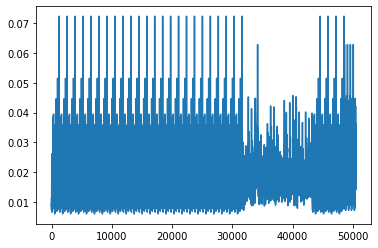

In [30]:
import matplotlib.pyplot as plt
plt.plot(range(len(std)),std['std'])
plt.show()

In [32]:
min(std['std'])

0.005914354558615358

In [51]:
small=std.loc[std['std']<0.006]

In [52]:
len(small)

28

In [53]:
small[['id','label','std','model_adcode']]

,id,label,std,model_adcode
525,0,275.0,0.005914,500023
1845,0,140.0,0.005914,500023
3165,0,226.0,0.005914,500023
4485,0,204.0,0.005914,500023
5805,0,204.0,0.005914,500023
7125,0,232.0,0.005914,500023
8445,0,259.0,0.005914,500023
9765,0,222.0,0.005914,500023
11085,0,255.0,0.005914,500023
12405,0,197.0,0.005914,500023


In [54]:
small_label=data.loc[data.model_adcode==500023]

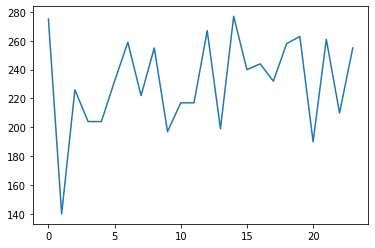

In [55]:
plt.plot(range(len(small_label)),small_label['label'])

In [33]:
small_label[['label','forecastVolum','id']]

,label,forecastVolum,id
34080,5.0,6.268610,0
34081,3.0,2.824905,0
34082,4.0,4.653045,0
34083,6.0,9.091709,0
34084,6.0,2.258758,0
34085,1.0,1.228598,0
34086,1.0,1.239884,0
34087,1.0,1.302493,0
34088,1.0,1.517744,0
34089,1.0,1.363575,0


In [67]:
std=(data.groupby('model_adcode')['label']).agg('std').reset_index(drop=False)
std['std']=std['label']
std.drop('label',axis=1,inplace=True)

In [70]:
std['std'].quantile(0.05)

22.990672150515564

In [89]:
std.loc[std['std']<10]

,model_adcode,std
72,110072,1.823756
223,140059,8.534669
272,150026,8.110536
286,150040,6.223931
564,310072,9.437725
981,360079,6.222330
1311,430081,7.207962
1420,450026,9.341256
1434,450040,6.841370
1473,450079,5.124359


In [74]:
new_std=pd.merge(data,std,on='model_adcode',how='left')

In [98]:
small=new_std.loc[new_std.model_adcode == 360079]

In [99]:
small

,ad_ry_mean,adcode,bodyType,bt_ry_mean,carCommentVolum,id,md_ry_mean,model,newsReplyVolum,popularity,province,regMonth,regYear,label,mt,model_adcode,model_adcode_mt,happyNY,model_adcode_mt_4,shift_model_adcode_mt_label_4,weightMonth,n_label,pred_label,forecastVolum,normalized_label,std
40584,347.210366,360000,2,591.955628,18.0,0,131.761364,79,20.0,11928.000,姹熻タ,1,2016,33.0,1,360079,36007901,0,36007905,50.0,6,3.496508,34.935429,36.196973,0.046218,6.22233
40585,347.210366,360000,2,591.955628,17.0,0,131.761364,79,11.0,11217.000,姹熻タ,2,2016,20.0,2,360079,36007902,1,36007906,27.0,6,2.995732,23.220279,22.946811,0.028011,6.22233
40586,347.210366,360000,2,591.955628,19.0,0,131.761364,79,10.0,11775.000,姹熻タ,3,2016,36.0,3,360079,36007903,0,36007907,36.0,6,3.583519,37.510005,36.247264,0.050420,6.22233
40587,347.210366,360000,2,591.955628,11.0,0,131.761364,79,1164.0,14555.000,姹熻タ,4,2016,32.0,4,360079,36007904,0,36007908,28.0,6,3.465736,29.614866,30.499909,0.044818,6.22233
40588,347.210366,360000,2,591.955628,16.0,0,131.761364,79,53.0,12212.000,姹熻タ,5,2016,29.0,5,360079,36007905,0,36007909,33.0,4,3.367296,29.830082,31.182108,0.040616,6.22233
40589,347.210366,360000,2,591.955628,16.0,0,131.761364,79,18.0,7675.000,姹熻タ,6,2016,24.0,6,360079,36007906,0,36007910,20.0,4,3.178054,24.477096,24.134671,0.033613,6.22233
40590,347.210366,360000,2,591.955628,12.0,0,131.761364,79,1161.0,16832.000,姹熻タ,7,2016,38.0,7,360079,36007907,0,36007911,36.0,4,3.637586,32.367269,30.900943,0.053221,6.22233
40591,347.210366,360000,2,591.955628,28.0,0,131.761364,79,67.0,17027.000,姹熻タ,8,2016,35.0,8,360079,36007908,0,36007912,32.0,4,3.555348,32.331602,31.862490,0.049020,6.22233
40592,347.210366,360000,2,591.955628,22.0,0,131.761364,79,15.0,5555.375,姹熻タ,9,2016,36.0,9,360079,36007909,0,36007913,29.0,4,3.583519,35.325779,34.599969,0.050420,6.22233
40593,347.210366,360000,2,591.955628,29.0,0,131.761364,79,43.0,5555.375,姹熻タ,10,2016,27.0,10,360079,36007910,0,36007914,24.0,4,3.295837,30.909604,31.314497,0.037815,6.22233


In [96]:
small.head()

,ad_ry_mean,adcode,bodyType,bt_ry_mean,carCommentVolum,id,md_ry_mean,model,newsReplyVolum,popularity,province,regMonth,regYear,label,mt,model_adcode,model_adcode_mt,happyNY,model_adcode_mt_4,shift_model_adcode_mt_label_4,weightMonth,n_label,pred_label,forecastVolum,normalized_label,std
34080,410.607724,110000,0,493.339238,1.0,0,225.878788,72,39.0,5555.375,鍖椾含,1,2016,5.0,1,110072,11007201,0,11007205,25.0,6,1.609438,5.748514,6.268610,0.092593,1.823756
34081,410.607724,110000,0,493.339238,1.0,0,225.878788,72,31.0,5555.375,鍖椾含,2,2016,3.0,2,110072,11007202,1,11007206,9.0,6,1.098612,3.075940,2.824905,0.055556,1.823756
34082,410.607724,110000,0,493.339238,1.0,0,225.878788,72,346.0,5555.375,鍖椾含,3,2016,4.0,3,110072,11007203,0,11007207,16.0,6,1.386294,4.649795,4.653045,0.074074,1.823756
34083,410.607724,110000,0,493.339238,1.0,0,225.878788,72,3019.0,5555.375,鍖椾含,4,2016,6.0,4,110072,11007204,0,11007208,36.0,6,1.791759,9.009072,9.091709,0.111111,1.823756
34084,410.607724,110000,0,493.339238,1.0,0,225.878788,72,48.0,5555.375,鍖椾含,5,2016,6.0,5,110072,11007205,0,11007209,5.0,4,1.791759,2.468776,2.258758,0.111111,1.823756


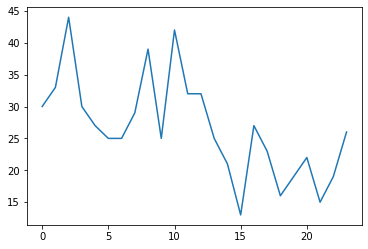

In [93]:
plt.plot(range(len(small)),small['label'])